In [1]:
import os,sys
import random
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
import matplotlib as plt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
### Enter the data folder name and WCR information

# Load the data folder path
path = os.getcwd()
path_upper = path + '/data_mortar'

# WCR information
WC_name_tag = [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]

# Fit the random seed
seed_data = 4885
random.seed(seed_data)
np.random.seed(seed_data)
os.environ["PYTHONHASHSEED"] = str(seed_data)
tf.random.set_seed(seed_data)

# Set the name of the training model file to save.
last_model_save_name = "WCRnet_wo_RC_34_layers.h5"
last_model_save_dir = path + f'/save_models/{last_model_save_name}'

# Layer paramter for WCRnet (w/o RC)
layer_list = [3, 4, 6, 3]

# Parameter for Training
epochs = 1000                 # training epochs
batch_sizes = 1024            # batch size
initial_learning_rate = 0.01   # initial learning rate
input_shape = 6               # input shape of the model

# Parameter for K-FOLD validation
k_fold_num = 4                # number of K-Folds
current_fold = 0              # Set the 'K' : 0 | 1 | 2 | 3

In [3]:
### Data normalization

# Normalize to the minimum and maximum sensor measurement values.
def sense_min_max_Normalization(input_data, min_value, max_value):
    data = (input_data - min_value) / (max_value - min_value) 
    
    return data

def data_set_normalization(data):
    # sensor_min_value
    vwc_min = 0
    ec_min = 0
    salinity_min = 0
    tds_min = 0
    epsilon_min = 0
    temp_min = -40
    
    # sensor_max_value
    vwc_max = 100
    ec_max = 20000
    salinity_max = 20000
    tds_max = 20000
    temp_max = 80
    epsilon_max = 82
    
    # sensor_normalization 
    data['TEMP'] = sense_min_max_Normalization(data['TEMP'],temp_min,temp_max)
    data['EC'] = sense_min_max_Normalization(data['EC'],ec_min,ec_max)
    data['VWC'] = sense_min_max_Normalization(data['VWC'],vwc_min,vwc_max)
    data['TDS'] = sense_min_max_Normalization(data['TDS'],tds_min,tds_max)
    data['SALINITY'] = sense_min_max_Normalization(data['SALINITY'],salinity_min,salinity_max)
    data['EPSILON'] = sense_min_max_Normalization(data['EPSILON'],epsilon_min,epsilon_max)
    
    return data

In [4]:
### Load FDR Data

path_list = []
path_under=os.listdir(path_upper)

# Load data_path
for i in range(len(path_under)): # collect under directory file path
    path_sub=os.listdir(path_upper+'/'+path_under[i])
    
    for j in range(len(path_sub)):
        path_list.append(path_upper+'/'+path_under[i]+'/'+path_sub[j])

# Create the zero matrix
data_list = [0]*len(path_list)
rand_x_data_list = [0]*len(path_list)
rand_y_data_list = [0]*len(path_list)

# Load data_value
for i,j in enumerate(path_list):
    data_list[i] =pd.read_csv(j)
    data_list[i] = data_set_normalization(data_list[i])

# Create the entire dataset.
total_data = pd.concat(data_list)
total_data = total_data.dropna()

# Print the data format
total_data

,WC_ratio,TEMP,EC,VWC,TDS,SALINITY,EPSILON
0,0.4,0.523083,0.18250,0.6175,0.09125,0.10035,0.690366
1,0.4,0.520667,0.18320,0.6234,0.09160,0.10075,0.698902
2,0.4,0.519000,0.18435,0.6234,0.09215,0.10135,0.698902
3,0.4,0.517917,0.18755,0.6278,0.09375,0.10315,0.705244
4,0.4,0.517000,0.18830,0.6326,0.09415,0.10355,0.711829
...,...,...,...,...,...,...,...
526,0.6,0.487667,0.29310,0.9488,0.14655,0.16120,0.967439
527,0.6,0.487667,0.29355,0.9488,0.14675,0.16145,0.967439
528,0.6,0.487667,0.29400,0.9488,0.14700,0.16170,0.967439
529,0.6,0.487667,0.29355,0.9488,0.14675,0.16145,0.967439


In [5]:
# GT-label (WCR)
y_R = round(total_data['WC_ratio']*100, 1)
y_data_total = y_R.to_numpy()

# FDR sensor data
x_R = total_data[['TEMP','VWC','EPSILON','SALINITY','TDS','EC']]
x_data_total = x_R.to_numpy()

In [6]:
# split train/test data
tmp_x_train, x_test, tmp_y_train, y_test = train_test_split(x_data_total.astype('float'), y_data_total.astype('float'), test_size=0.2, random_state=seed_data)

# splot train/valid data
x_train_kfold = []
x_valid_kfold = []
y_train_kfold = []
y_valid_kfold = []

kfold = KFold(n_splits=k_fold_num)

for train_idx, valid_idx in kfold.split(tmp_x_train):
    x_train_kfold.append(tmp_x_train[train_idx])
    x_valid_kfold.append(tmp_x_train[valid_idx])
    y_train_kfold.append(tmp_y_train[train_idx])
    y_valid_kfold.append(tmp_y_train[valid_idx])

# Print the quantity of data
print(f"quantity of train data : {len(x_train_kfold[0])}")
print(f"quantity of validation data : {len(x_valid_kfold[0])}")
print(f"quantity of test data : {len(y_test)}")

quantity of train data : 14010
quantity of validation data : 4670
quantity of test data : 4670


In [7]:
### Create WCRnet (w/o RC)

print("tf_version : %s" %tf.__version__)

def layer_1(x):    
    x = tf.keras.layers.Dense(32, kernel_initializer='normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
 
    return x   
 
    
def layer_2(x):       
 
    for i in range(layer_list[0]): 
        
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)     
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)     
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
      
    return x
 
  
def layer_3(x):        
    
    for i in range(layer_list[1]):  
        
        x = tf.keras.layers.Dense(128, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    
        x = tf.keras.layers.Dense(128, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)   
            
    return x
 
  
def layer_4(x):   
    
    for i in range(layer_list[2]): 
            
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)  
            
    return x
 
  
def layer_5(x):
    
    for i in range(layer_list[3]): 

        x = tf.keras.layers.Dense(32, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    
        x = tf.keras.layers.Dense(32, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)  

        shortcut = x      
            
    return x

# Learning rate scheduler
def lr_exp_decay(epoch, lr):
    if epoch <50:
        return initial_learning_rate
    
    elif epoch >=50 and epoch <100:
        return initial_learning_rate * 0.1
    
    elif epoch >=100 and epoch <300:
        return initial_learning_rate * 0.01
    
    elif epoch >=300 and epoch <500:
        return initial_learning_rate * 0.001
    
    else:
        return initial_learning_rate * 0.0001

tf_version : 2.6.2


In [8]:
### Compile WCRnet (w/o RC)

input_tensor =  tf.keras.Input(shape=(input_shape,))

x = layer_1(input_tensor)
x = layer_2(x)
x = layer_3(x)
x = layer_4(x)
x = layer_5(x)
 
output_tensor = tf.keras.layers.Dense(1, kernel_initializer='normal')(x)
output_tensor = tf.keras.activations.relu(output_tensor)

model = tf.keras.Model(input_tensor, output_tensor)
model.summary()

start_model=model.get_weights()
counter  = 0

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                224       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
tf.nn.relu_1 (TFOpLambda)    (None, 64)                0     

In [9]:
### Training WCRnet (w/o RC)

train_mode = True

if train_mode == True:
    # Load the learning rate scheduler
    lr_s = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

    # Load the Early Stopping
    early_stop = tf.keras.callbacks.EarlyStopping(patience=300, min_delta=3, monitor='val_loss')    
    
    # model compile
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

    # training
    history = model.fit(x_train_kfold[current_fold], y_train_kfold[current_fold], validation_data=(x_valid_kfold[current_fold], y_valid_kfold[current_fold]), epochs=epochs, batch_size=batch_sizes, callbacks=[lr_s, early_stop])

    # save the DL-R model
    model.save(last_model_save_dir)

Epoch 1/1000
14/14 [==============================] - 8s 130ms/step - loss: 2434.1858 - val_loss: 2478.2478
Epoch 2/1000
14/14 [==============================] - 1s 76ms/step - loss: 2113.7456 - val_loss: 2350.3933
Epoch 3/1000
14/14 [==============================] - 1s 63ms/step - loss: 1683.2614 - val_loss: 1307.3307
Epoch 4/1000
14/14 [==============================] - 1s 62ms/step - loss: 1186.1082 - val_loss: 42187.0000
Epoch 5/1000
14/14 [==============================] - 1s 67ms/step - loss: 721.2516 - val_loss: 1187.7870
Epoch 6/1000
14/14 [==============================] - 1s 62ms/step - loss: 334.9375 - val_loss: 6728.1240
Epoch 7/1000
14/14 [==============================] - 1s 67ms/step - loss: 98.3589 - val_loss: 2455.1079
Epoch 8/1000
14/14 [==============================] - 1s 71ms/step - loss: 37.5254 - val_loss: 2277.0159
Epoch 9/1000
14/14 [==============================] - 1s 69ms/step - loss: 37.9598 - val_loss: 1154.4476
Epoch 10/1000
14/14 [======================

Epoch 80/1000
14/14 [==============================] - 1s 70ms/step - loss: 8.3634 - val_loss: 19.5596
Epoch 81/1000
14/14 [==============================] - 1s 70ms/step - loss: 8.3340 - val_loss: 14.3306
Epoch 82/1000
14/14 [==============================] - 1s 64ms/step - loss: 8.6971 - val_loss: 9.0474
Epoch 83/1000
14/14 [==============================] - 1s 62ms/step - loss: 8.2462 - val_loss: 10.6373
Epoch 84/1000
14/14 [==============================] - 1s 68ms/step - loss: 8.5471 - val_loss: 11.3608
Epoch 85/1000
14/14 [==============================] - 1s 65ms/step - loss: 8.3220 - val_loss: 10.3194
Epoch 86/1000
14/14 [==============================] - 1s 68ms/step - loss: 7.9723 - val_loss: 9.9893
Epoch 87/1000
14/14 [==============================] - 1s 71ms/step - loss: 7.8663 - val_loss: 10.0906
Epoch 88/1000
14/14 [==============================] - 1s 67ms/step - loss: 7.9061 - val_loss: 13.1612
Epoch 89/1000
14/14 [==============================] - 1s 67ms/step - loss:

14/14 [==============================] - 1s 62ms/step - loss: 6.6312 - val_loss: 7.3494
Epoch 160/1000
14/14 [==============================] - 1s 60ms/step - loss: 6.6148 - val_loss: 7.4415
Epoch 161/1000
14/14 [==============================] - 1s 64ms/step - loss: 6.6361 - val_loss: 7.5595
Epoch 162/1000
14/14 [==============================] - 1s 62ms/step - loss: 6.7956 - val_loss: 7.7001
Epoch 163/1000
14/14 [==============================] - 1s 66ms/step - loss: 6.4842 - val_loss: 7.6404
Epoch 164/1000
14/14 [==============================] - 1s 63ms/step - loss: 6.5600 - val_loss: 7.3082
Epoch 165/1000
14/14 [==============================] - 1s 61ms/step - loss: 6.7037 - val_loss: 6.7385
Epoch 166/1000
14/14 [==============================] - 1s 59ms/step - loss: 6.7971 - val_loss: 6.8390
Epoch 167/1000
14/14 [==============================] - 1s 61ms/step - loss: 6.5228 - val_loss: 6.9711
Epoch 168/1000
14/14 [==============================] - 1s 65ms/step - loss: 6.5423 - va

14/14 [==============================] - 1s 64ms/step - loss: 4.6146 - val_loss: 4.6484
Epoch 239/1000
14/14 [==============================] - 1s 68ms/step - loss: 4.5303 - val_loss: 4.3868
Epoch 240/1000
14/14 [==============================] - 1s 65ms/step - loss: 4.6619 - val_loss: 5.0855
Epoch 241/1000
14/14 [==============================] - 1s 63ms/step - loss: 4.7268 - val_loss: 6.0514
Epoch 242/1000
14/14 [==============================] - 1s 71ms/step - loss: 4.6064 - val_loss: 6.2896
Epoch 243/1000
14/14 [==============================] - 1s 66ms/step - loss: 4.4992 - val_loss: 7.2339
Epoch 244/1000
14/14 [==============================] - 1s 74ms/step - loss: 4.3507 - val_loss: 6.3514
Epoch 245/1000
14/14 [==============================] - 1s 76ms/step - loss: 4.8538 - val_loss: 6.8671
Epoch 246/1000
14/14 [==============================] - 1s 61ms/step - loss: 4.3797 - val_loss: 5.6111
Epoch 247/1000
14/14 [==============================] - 1s 62ms/step - loss: 4.5561 - va

14/14 [==============================] - 1s 71ms/step - loss: 4.0757 - val_loss: 3.6117
Epoch 318/1000
14/14 [==============================] - 1s 67ms/step - loss: 3.9799 - val_loss: 3.5999
Epoch 319/1000
14/14 [==============================] - 1s 71ms/step - loss: 3.9042 - val_loss: 3.6472
Epoch 320/1000
14/14 [==============================] - 1s 64ms/step - loss: 3.9762 - val_loss: 3.6595
Epoch 321/1000
14/14 [==============================] - 1s 66ms/step - loss: 3.9988 - val_loss: 3.6079
Epoch 322/1000
14/14 [==============================] - 1s 69ms/step - loss: 3.9132 - val_loss: 3.5248
Epoch 323/1000
14/14 [==============================] - 1s 66ms/step - loss: 4.1653 - val_loss: 3.6440
Epoch 324/1000
14/14 [==============================] - 1s 68ms/step - loss: 4.2591 - val_loss: 3.6790
Epoch 325/1000
14/14 [==============================] - 1s 62ms/step - loss: 3.8687 - val_loss: 3.6706
Epoch 326/1000
14/14 [==============================] - 1s 69ms/step - loss: 3.9080 - va

14/14 [==============================] - 1s 65ms/step - loss: 3.8102 - val_loss: 3.5939
Epoch 397/1000
14/14 [==============================] - 1s 69ms/step - loss: 3.8372 - val_loss: 3.5658
Epoch 398/1000
14/14 [==============================] - 1s 71ms/step - loss: 3.8898 - val_loss: 3.5782
Epoch 399/1000
14/14 [==============================] - 1s 64ms/step - loss: 3.9914 - val_loss: 3.6009
Epoch 400/1000
14/14 [==============================] - 1s 71ms/step - loss: 4.0321 - val_loss: 3.5967
Epoch 401/1000
14/14 [==============================] - 1s 70ms/step - loss: 3.9757 - val_loss: 3.5616
Epoch 402/1000
14/14 [==============================] - 1s 67ms/step - loss: 3.8836 - val_loss: 3.5593
Epoch 403/1000
14/14 [==============================] - 1s 73ms/step - loss: 4.1406 - val_loss: 3.5423
Epoch 404/1000
14/14 [==============================] - 1s 65ms/step - loss: 3.8332 - val_loss: 3.5500
Epoch 405/1000
14/14 [==============================] - 1s 69ms/step - loss: 3.7796 - va

14/14 [==============================] - 1s 63ms/step - loss: 3.8541 - val_loss: 3.5641
Epoch 476/1000
14/14 [==============================] - 1s 69ms/step - loss: 3.8204 - val_loss: 3.5554
Epoch 477/1000
14/14 [==============================] - 1s 62ms/step - loss: 3.8701 - val_loss: 3.5389
Epoch 478/1000
14/14 [==============================] - 1s 68ms/step - loss: 3.8617 - val_loss: 3.5533
Epoch 479/1000
14/14 [==============================] - 1s 63ms/step - loss: 3.7786 - val_loss: 3.5536
Epoch 480/1000
14/14 [==============================] - 1s 63ms/step - loss: 3.7927 - val_loss: 3.4917
Epoch 481/1000
14/14 [==============================] - 1s 68ms/step - loss: 3.7353 - val_loss: 3.4853
Epoch 482/1000
14/14 [==============================] - 1s 63ms/step - loss: 3.7309 - val_loss: 3.4712
Epoch 483/1000
14/14 [==============================] - 1s 67ms/step - loss: 3.7580 - val_loss: 3.4958
Epoch 484/1000
14/14 [==============================] - 1s 75ms/step - loss: 3.8452 - va

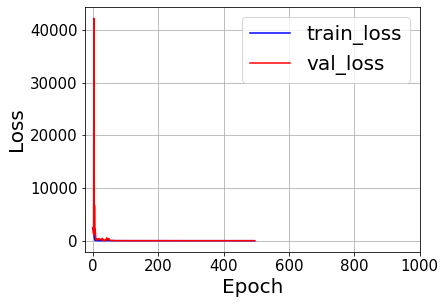

In [10]:
# Plot the Loss graph

if train_mode == True:
    plt.subplots(figsize=(6,4.5))
    plt.plot(history.history['loss'],'b-',label='train_loss')
    plt.plot(history.history['val_loss'],'b-',label='val_loss',color='r')

    plt.legend(prop={'size': 20})

    plt.xlabel("Epoch", fontdict={'size': 20})
    plt.ylabel("Loss", fontdict={'size': 20})

    plt.xticks((0, 200, 400, 600, 800, 1000),fontsize=15)
    plt.yticks(fontsize=15)

    plt.grid(True)
    plt.show()

In [11]:
### Print the prediction results

test_losses = []
p_result_0 = []

# Load Model & Make Results
model.load_weights(last_model_save_dir)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

test_losses = model.evaluate(x_test, y_test, verbose=0)
p_result_0 = model.predict(x_test)

p_result_0

array([[59.964977],
       [55.049282],
       [47.40244 ],
       ...,
       [40.141094],
       [48.208256],
       [55.099777]], dtype=float32)

In [12]:
### print RMSE and R2-score

rmse_0 = round(mean_squared_error(y_test, p_result_0, squared=False), 4)
r2_0 = round(r2_score(y_test, p_result_0), 4)

print(f"RMSE : {rmse_0}")
print(f"r2_score : {r2_0}")

RMSE : 1.8685
r2_score : 0.9167


In [13]:
# Preprocess the results (group by the same y-value).
p_list_0 = [[]for i in range(len(WC_name_tag))]

for i,test_water in enumerate(y_test):    
    for j,wc_name in enumerate(WC_name_tag):
        
        if i==len(y_test):
            break
            
        # If the actual water-cement ratio and the estimated water-cement ratio are the same, append to p_list.
        if(np.round(test_water,3)==wc_name):
            p_list_0[j].append(p_result_0[i])
         
p_list_0

[[array([40.14078], dtype=float32),
  array([43.14448], dtype=float32),
  array([40.13925], dtype=float32),
  array([40.13928], dtype=float32),
  array([40.135555], dtype=float32),
  array([42.22234], dtype=float32),
  array([40.13998], dtype=float32),
  array([40.14035], dtype=float32),
  array([40.140663], dtype=float32),
  array([40.123154], dtype=float32),
  array([40.135128], dtype=float32),
  array([40.12719], dtype=float32),
  array([44.86912], dtype=float32),
  array([42.132347], dtype=float32),
  array([40.14005], dtype=float32),
  array([40.133472], dtype=float32),
  array([40.139256], dtype=float32),
  array([40.133427], dtype=float32),
  array([40.13122], dtype=float32),
  array([40.13889], dtype=float32),
  array([40.124416], dtype=float32),
  array([40.12255], dtype=float32),
  array([40.13497], dtype=float32),
  array([40.139023], dtype=float32),
  array([40.13825], dtype=float32),
  array([40.124332], dtype=float32),
  array([40.14101], dtype=float32),
  array([40.13507

In [14]:
### Print the mean and standard deviation of the predicted WCR (Water-Cement Ratio).

p_list_mean = [[]for i in range(len(WC_name_tag))]
p_list_std = [[]for i in range(len(WC_name_tag))]

for i in range(len(WC_name_tag)):
    tmp_mean = np.mean(p_list_0[i])
    tmp_std = np.std(p_list_0[i])
    
    p_list_mean[i].append(tmp_mean)
    p_list_std[i].append(tmp_std)

flattened_mean = [item for sublist in p_list_mean for item in sublist]
flattened_std = [item for sublist in p_list_std for item in sublist]

print(f"mean per WCR: {flattened_mean}\n")
print(f"std per WCR: {flattened_std}")

mean per WCR: [40.664864, 43.90611, 45.980507, 46.93843, 49.394745, 52.287106, 54.136265, 57.27036, 59.52501]

std per WCR: [1.4314181, 1.9828962, 1.8279079, 1.9627285, 1.930566, 2.0534663, 1.3559692, 1.6540905, 0.6551183]


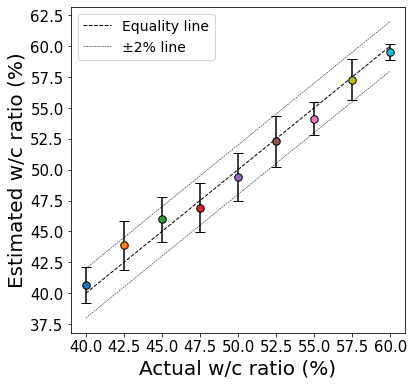

In [15]:
### Plot graph

x_axis = [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]
y_axis = [37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots(figsize=(6, 6))

for i, tmp_color in enumerate(colors):
    ax.errorbar(WC_name_tag[i], flattened_mean[i], yerr=flattened_std[i], linestyle='None', markeredgecolor='k', ecolor='k', marker='o', markersize=7.5, color=tmp_color, capsize=5, elinewidth=1.5)

# equal line
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], c='k', ls='--', lw=1, label='Equality line')

# upper line
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [42, 44.5, 47, 49.5, 52, 54.5, 57, 59.5, 62], c='k', ls='--', lw=0.5, label='±2% line')

# under lone
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [38, 40.5, 43, 45.5, 48, 50.5, 53, 55.5, 58], c='k', ls='--', lw=0.5)

plt.xlabel('Actual w/c ratio (%)', fontdict={'size': 20})
plt.ylabel('Estimated w/c ratio (%)', fontdict={'size': 20})
plt.xticks(x_axis, fontsize=15)
plt.yticks(y_axis, fontsize=15)
plt.legend(fontsize=14)

plt.show()